In [206]:
import pandas as pd

df = pd.read_csv('oil_price.csv')
df

,date,close
0,2000-08-23 00:00:00-04:00,32.049999
1,2000-08-24 00:00:00-04:00,31.629999
2,2000-08-25 00:00:00-04:00,32.049999
3,2000-08-28 00:00:00-04:00,32.869999
4,2000-08-29 00:00:00-04:00,32.720001
...,...,...
5837,2023-11-22 00:00:00-05:00,77.099998
5838,2023-11-24 00:00:00-05:00,75.540001
5839,2023-11-27 00:00:00-05:00,74.860001
5840,2023-11-28 00:00:00-05:00,76.410004


In [208]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df

,date,close
0,2000-08-23 04:00:00+00:00,32.049999
1,2000-08-24 04:00:00+00:00,31.629999
2,2000-08-25 04:00:00+00:00,32.049999
3,2000-08-28 04:00:00+00:00,32.869999
4,2000-08-29 04:00:00+00:00,32.720001
...,...,...
5837,2023-11-22 05:00:00+00:00,77.099998
5838,2023-11-24 05:00:00+00:00,75.540001
5839,2023-11-27 05:00:00+00:00,74.860001
5840,2023-11-28 05:00:00+00:00,76.410004


In [155]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

df['cos_year'] = np.cos((df['year'] - df['year'].min()) / (2024 - df['year'].min()) * (2 * np.pi))
df['cos_month'] = np.cos((df['month'] - df['month'].min()) / (df['month'].max() - df['month'].min()) * (2 * np.pi))
df['cos_day'] = np.cos((df['day'] - df['day'].min()) / (df['day'].max() - df['day'].min()) * (2 * np.pi))

In [212]:
df.drop(['date', 'year', 'month', 'day'], axis=1, inplace=True)
df

,close,cos_year,sin_year,cos_month,sin_month,cos_day,sin_day
0,32.049999,-0.988368,0.152079,-0.500000,-0.866025,-0.050649,-0.998717
1,31.629999,-0.988368,0.152079,-0.500000,-0.866025,0.151428,-0.988468
2,32.049999,-0.988368,0.152079,-0.500000,-0.866025,0.347305,-0.937752
3,32.869999,-0.988368,0.152079,-0.500000,-0.866025,0.820763,-0.571268
4,32.720001,-0.988368,0.152079,-0.500000,-0.866025,0.918958,-0.394356
...,...,...,...,...,...,...,...
5837,77.099998,-0.970624,-0.240600,0.866025,-0.500000,-0.250653,-0.968077
5838,75.540001,-0.970624,-0.240600,0.866025,-0.500000,0.151428,-0.988468
5839,74.860001,-0.970624,-0.240600,0.866025,-0.500000,0.688967,-0.724793
5840,76.410004,-0.970624,-0.240600,0.866025,-0.500000,0.820763,-0.571268


<AxesSubplot:xlabel='date'>

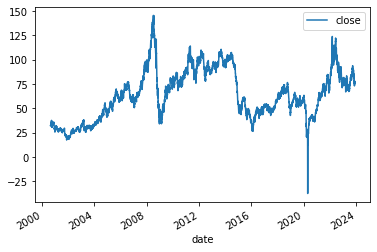

In [75]:
df.plot()

In [209]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day'].max()

31

In [210]:
df['cos_year'] = np.cos(2 * np.pi * df['year'] / 365.25)  # Assuming a year has 365.25 days
df['sin_year'] = np.sin(2 * np.pi * df['year'] / 365.25)

df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)

df['cos_day'] = np.cos(2 * np.pi * df['day'] / 31)  # Assuming a month has 31 days
df['sin_day'] = np.sin(2 * np.pi * df['day'] / 31)

In [223]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X = df[['cos_year', 'sin_year', 'cos_month', 'sin_month', 'cos_day', 'sin_day']]
y = df['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [166]:
import lightgbm as lgb

# Define the LightGBM regressor
lgb_train = lgb.LGBMRegressor()

In [214]:
X_train

,cos_year,sin_year,cos_month,sin_month,cos_day,sin_day
0,-0.988368,0.152079,-0.5,-0.866025,-0.050649,-0.998717
1,-0.988368,0.152079,-0.5,-0.866025,0.151428,-0.988468
2,-0.988368,0.152079,-0.5,-0.866025,0.347305,-0.937752
3,-0.988368,0.152079,-0.5,-0.866025,0.820763,-0.571268
4,-0.988368,0.152079,-0.5,-0.866025,0.918958,-0.394356
...,...,...,...,...,...,...
4668,-0.984870,-0.173295,-0.5,0.866025,0.820763,0.571268
4669,-0.984870,-0.173295,-0.5,0.866025,0.688967,0.724793
4670,-0.984870,-0.173295,-0.5,0.866025,0.528964,0.848644
4671,-0.984870,-0.173295,-0.5,0.866025,-0.050649,0.998717


In [193]:
params = {
    'objective': 'regression',
    'metric': 'mse',  # Mean Squared Error
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [215]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [224]:
lgbm_model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

c:\Users\Acer\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 4673, number of used features: 6
[LightGBM] [Info] Start training from score 63.242106
[1]	valid_0's l2: 468.264
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 471.727
[3]	valid_0's l2: 471.522
[4]	valid_0's l2: 471.054
[5]	valid_0's l2: 474.419
[6]	valid_0's l2: 473.855
[7]	valid_0's l2: 473.45
[8]	valid_0's l2: 473.543
[9]	valid_0's l2: 473.272
[10]	valid_0's l2: 475.785
[11]	valid_0's l2: 475.734
[12]	valid_0's l2: 475.811
[13]	valid_0's l2: 478.202
[14]	valid_0's l2: 478.213
[15]	valid_0's l2: 478.191
[16]	valid_0's l2: 480.38
[17]	valid_0's l2: 483.096
[18]	valid_0's l2: 483.114
[19]	valid_0's l2: 485.718
[20]	valid_0's l2: 485.96
[21]	valid_0's l2: 486.017
[22]	valid_0's l2: 488.567
[23]	valid_0's

In [225]:
y_pred = lgbm_model.predict(X_test)
y_pred

array([63.49817206, 63.49817206, 63.49817206, ..., 63.03405988,
       63.03405988, 63.03405988])

In [226]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 
 

MSE: 468.26
RMSE: 21.64


In [227]:
start_date = pd.to_datetime('today').normalize()
end_date = start_date + pd.DateOffset(days=60)

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df_next = pd.DataFrame(date_range)


In [228]:
df_next

,0
0,2023-11-29
1,2023-11-30
2,2023-12-01
3,2023-12-02
4,2023-12-03
...,...
56,2024-01-24
57,2024-01-25
58,2024-01-26
59,2024-01-27


In [ ]:
df_next['year'] = df_next[0].dt.year
df_next['month'] = df_next[0].dt.month
df_next['day'] = df_next[0].dt.day

df_next['cos_year'] = np.cos(2 * np.pi * df_next['year'] / 365.25)  # Assuming a year has 365.25 days
df_next['sin_year'] = np.sin(2 * np.pi * df_next['year'] / 365.25)

df_next['cos_month'] = np.cos(2 * np.pi * df_next['month'] / 12)
df_next['sin_month'] = np.sin(2 * np.pi * df_next['month'] / 12)

df_next['cos_day'] = np.cos(2 * np.pi * df_next['day'] / 31)  # Assuming a month has 31 days
df_next['sin_day'] = np.sin(2 * np.pi * df_next['day'] / 31)

In [237]:

# df_next.drop([0, 'year', 'month', 'day'], axis=1, inplace=True)
df_next

,cos_year,sin_year,cos_month,sin_month,cos_day,sin_day
0,-0.970624,-0.240600,0.866025,-5.000000e-01,0.918958,-0.394356
1,-0.970624,-0.240600,0.866025,-5.000000e-01,0.979530,-0.201299
2,-0.970624,-0.240600,1.000000,-2.449294e-16,0.979530,0.201299
3,-0.970624,-0.240600,1.000000,-2.449294e-16,0.918958,0.394356
4,-0.970624,-0.240600,1.000000,-2.449294e-16,0.820763,0.571268
...,...,...,...,...,...,...
56,-0.966342,-0.257261,0.866025,5.000000e-01,0.151428,-0.988468
57,-0.966342,-0.257261,0.866025,5.000000e-01,0.347305,-0.937752
58,-0.966342,-0.257261,0.866025,5.000000e-01,0.528964,-0.848644
59,-0.966342,-0.257261,0.866025,5.000000e-01,0.688967,-0.724793


In [238]:
y_pred_next = lgbm_model.predict(df_next)
y_pred_next

array([63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988, 63.03405988, 63.03405988, 63.03405988, 63.03405988,
       63.03405988])